<a href="https://colab.research.google.com/github/Laimo64/Laimo64/blob/main/AI_surgery_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown --fuzzy https://drive.google.com/file/d/1y8OFnIFYC_b_WIexKSog732_L78Pegxa/view?usp=drive_link

Downloading...
From (original): https://drive.google.com/uc?id=1y8OFnIFYC_b_WIexKSog732_L78Pegxa
From (redirected): https://drive.google.com/uc?id=1y8OFnIFYC_b_WIexKSog732_L78Pegxa&confirm=t&uuid=662fbd7d-7c97-467c-83ba-659a8bf6de09
To: /content/brain_small.zip
100% 119M/119M [00:01<00:00, 88.3MB/s]


In [2]:
!unzip -q brain_small.zip

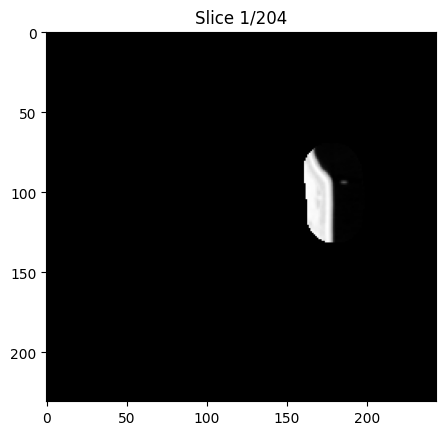

In [6]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from monai.transforms import LoadImage
import os

# 加載 NIfTI 檔案
nii_file = "/content/1BA001/ct.nii.gz"

# 確認檔案是否存在
if not os.path.exists(nii_file):
    raise FileNotFoundError(f"檔案 {nii_file} 不存在，請確認路徑是否正確。")

# 使用 MONAI 加載影像
image_loader = LoadImage(image_only=True)
image = image_loader(nii_file)

# 設置動畫顯示
fig, ax = plt.subplots()
slice_display = ax.imshow(image[:, :, 0], cmap="gray")
title = ax.set_title("Slice 1")

# 更新每一幀的內容
def update(slice_index):
    slice_display.set_data(image[:, :, slice_index])
    title.set_text(f"Slice {slice_index + 1}/{image.shape[-1]}")
    return slice_display, title

# 動畫設置
anim = FuncAnimation(fig, update, frames=image.shape[-1], interval=100, blit=True)
plt.show()


In [5]:
pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.3 MB/s eta 0:00:00


Data Preprocess

In [7]:
import os
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class MRCTDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.samples = []
        for root, _, files in os.walk(data_dir):
            if "mr.nii.gz" in files and "ct.nii.gz" in files:
                self.samples.append(root)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_path = self.samples[idx]
        mr = nib.load(os.path.join(sample_path, "mr.nii.gz")).get_fdata()
        ct = nib.load(os.path.join(sample_path, "ct.nii.gz")).get_fdata()

        # Normalize to Z-score
        mr = (mr - np.mean(mr)) / np.std(mr)
        ct = (ct - np.mean(ct)) / np.std(ct)

        mr, ct = torch.tensor(mr, dtype=torch.float32), torch.tensor(ct, dtype=torch.float32)
        if self.transform:
            mr = self.transform(mr)
            ct = self.transform(ct)

        return mr.unsqueeze(0), ct.unsqueeze(0)  # Add channel dimension

# Example usage
train_dataset = MRCTDataset(data_dir="Task1/brain", transform=transforms.Resize((160, 160)))
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MESP(Structure)

In [ ]:
import torch
import torch.nn as nn

# Swin Transformer Block (簡化版)
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_size):
        super(SwinTransformerBlock, self).__init__()
        self.norm = nn.LayerNorm(dim)
        self.fc = nn.Linear(dim, dim)
        self.window_size = input_size // 4  # 分割窗口

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, -1, c)  # 展平為序列
        x = self.norm(x)
        x = self.fc(x)
        return x.view(b, c, h, w)

# MSEP 網路
class MSEP(nn.Module):
    def __init__(self):
        super(MSEP, self).__init__()
        # Encoder 部分
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        # Skip 連接部分 + RDSformer
        self.skip = SwinTransformerBlock(128, input_size=160)
        # Decoder 部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        enc = self.encoder(x)
        skip = self.skip(enc)
        dec = self.decoder(skip)
        return dec

# Initialize model
model = MSEP()


Training

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

# 設置訓練設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 優化器與損失函數
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.L1Loss()

# 訓練迴圈
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for mr, ct in train_loader:
        mr, ct = mr.to(device), ct.to(device)
        optimizer.zero_grad()
        output = model(mr)
        loss = criterion(output, ct)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")


Test

In [ ]:
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        for mr, ct in test_loader:
            mr = mr.to(device)
            output = model(mr)
            # 後處理（例如將預測結果儲存為 .nii.gz）
            output = output.cpu().numpy()
            # Save output here...

test_loader = DataLoader(MRCTDataset(data_dir="Task1/pelvis"), batch_size=1, shuffle=False)
test_model(model, test_loader)
